# Procesamiento
Vamos a utilizar sklearn para el procesamiento de datos mediante pipelines.
- Buena info de cómo hacer esto aquí: https://www.youtube.com/watch?v=0B5eIE_1vpU&t=1227s

In [18]:
import pandas as pd
pd.set_option('display.max_columns', None)

train = pd.read_csv('../data/train_data.csv')
test = pd.read_csv('../data/test_data.csv')

In [19]:
# Vamos a definir los datos de entrenamiento
X = train.drop(['mineralType', 'id'], axis=1)
y = train['mineralType']

In [10]:
y = y.drop(y[X['climaticZone']==3].index)
X = X.drop(X[X['climaticZone']==3].index)
y = y.drop(y[X['geoZone']==5].index.values)
X = X.drop(X[X['geoZone']==5].index.values)

In [11]:
# Create sklearn pipeline for data preprocessing
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, StandardScaler, RobustScaler
from sklearn.feature_extraction import FeatureHasher
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import LinearSVC
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer, recall_score, precision_score
from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn import set_config
import numpy as np
import mlflow
import math
from joblib import Memory
from shutil import rmtree

mlflow.sklearn.autolog()
mlflow.set_experiment("knnclassifier")

preprocessor = ColumnTransformer([
        # (name, transformer, columns)
        ("temperatureFirstHalfPlanetRotation", make_pipeline(IterativeImputer(missing_values=-999.0), FunctionTransformer(lambda f: (f - 32) / 1.8, feature_names_out="one-to-one"), RobustScaler()), ['temperatureFirstHalfPlanetRotation']), # convert from Fahrenheit to Celsius
        ("temperatureSecondHalfPlanetRotation", StandardScaler(), ['temperatureSecondHalfPlanetRotation']), # pass through the column unchanged
        ("waterStreamDistanceX", make_pipeline(FunctionTransformer(lambda f: f * 0.3048, feature_names_out="one-to-one"), StandardScaler()), ['waterStreamDistanceX']), # convert from feet to meters
        ("waterStreamDistanceY", StandardScaler(), ['waterStreamDistanceY']), # pass through the column unchanged
        ("planetSection", OneHotEncoder(handle_unknown = "ignore"), ['planetSection']), # one-hot encode the planetSection column
        ("cover", OneHotEncoder(handle_unknown='error', drop='first'), ['cover']), # one-hot encode the cover column and drop the first column (the one with the missing values == 0)
        ("climaticZone", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ['climaticZone']), # ordinal encode the climaticZone column TODO: drop category 3? what to do? only one row has a 3
        ("geoZone", OneHotEncoder(handle_unknown = "ignore"), ['geoZone']), # one-hot encode the geoZone column TODO: drop category 5?
        ("rockSize", OneHotEncoder(handle_unknown='ignore', drop='first'), ['rockSize']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0)
        ("magmaConcentrationDistance", OneHotEncoder(handle_unknown = "ignore"), ['magmaConcentrationDistance']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0) TODO: use Ordinal Encoder?
        ("mineralDensity", make_pipeline(IterativeImputer(missing_values=-999.0), RobustScaler()), ['mineralDensity']), # pass through the column unchanged
        ("detectionDepth", StandardScaler(), ['detectionDepth']), # pass through the column unchanged TODO: convert km to m?
        ("longitude", StandardScaler(), ['longitude']), # pass through the column unchanged TODO: values > 360? do x - 360
    ],
    verbose_feature_names_out=False, remainder='passthrough'
)

def euclidean_distance(x, y):
    res = []
    for i in range(len(x)):
        res.append(math.sqrt(x[i]**2 + y[i]**2))
    return np.array(res)

class CreateVariables(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        # waterSteamDistance
        waterStreamDistanceX = X[:,2]
        waterStreamDistanceY = X[:,3]
        waterStreamDistance = euclidean_distance(waterStreamDistanceX, waterStreamDistanceY)
        X = np.append(X, waterStreamDistance.reshape(-1, 1), axis=1)

        # temperature (both planet rotations)
        temperatureFirstHalfPlanetRotation = X[:,0]
        temperatureSecondHalfPlanetRotation = X[:,1]
        meanTemperature = (temperatureFirstHalfPlanetRotation + temperatureSecondHalfPlanetRotation)/2
        X = np.append(X, meanTemperature.reshape(-1, 1), axis=1)

        return X

# model = MLPClassifier(random_state=1, max_iter=300)
model = KNeighborsClassifier()
# model = RandomForestClassifier(bootstrap=False, max_features=5, min_samples_leaf=15,
#                          n_estimators=512, n_jobs=-1, random_state=1,
#                          warm_start=True)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('create_variables', CreateVariables()),
    ('pca', PCA()),
    ('model', 'passthrough')
])

param_grid = [
    {
        # 'preprocessor__temperatureFirstHalfPlanetRotation__robustscaler': [StandardScaler(), RobustScaler()],
        'pca__n_components': [None],
        'model': [KNeighborsClassifier()],
        'model__n_neighbors': [7],
        'model__weights': ['distance'],
        'model__metric': ['manhattan'],
    },
    # {
    #     # 'preprocessor__temperatureFirstHalfPlanetRotation__robustscaler': [StandardScaler(), RobustScaler()],
    #     'pca__n_components': [None],
    #     'model': [GradientBoostingClassifier()],
    # },
]

grid = GridSearchCV(pipe, cv=10, scoring=['accuracy', 'precision_macro'], error_score='raise', return_train_score=True, n_jobs=-1, verbose=4, refit='accuracy',
        param_grid=param_grid
        )

# Train the model
grid.fit(X, y)

set_config(display='diagram')
# grid.get_para ms()

2022/04/28 22:51:24 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of sklearn. If you encounter errors during autologging, try upgrading / downgrading sklearn to a supported version, or try upgrading MLflow.
2022/04/28 22:51:24 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '20291567f33f4796bba178067bf42752', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/04/28 22:51:24 WARNING mlflow.utils: Truncated the value of the key `estimator`. Truncated value: `Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('temperatureFirstHalfPlanetRotation',
                                                  Pipeline(steps=[...`


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV 1/10] END model=KNeighborsClassifier(), model__metric=manhattan, model__n_neighbors=7, model__weights=distance, pca__n_components=None; accuracy: (train=1.000, test=0.725) precision_macro: (train=1.000, test=0.720) total time=   0.4s
[CV 3/10] END model=KNeighborsClassifier(), model__metric=manhattan, model__n_neighbors=7, model__weights=distance, pca__n_components=None; accuracy: (train=1.000, test=0.731) precision_macro: (train=1.000, test=0.727) total time=   0.3s
[CV 7/10] END model=KNeighborsClassifier(), model__metric=manhattan, model__n_neighbors=7, model__weights=distance, pca__n_components=None; accuracy: (train=1.000, test=0.745) precision_macro: (train=1.000, test=0.739) total time=   0.4s
[CV 8/10] END model=KNeighborsClassifier(), model__metric=manhattan, model__n_neighbors=7, model__weights=distance, pca__n_components=None; accuracy: (train=1.000, test=0.732) precision_macro: (train=1.000, test=0.730) total 

2022/04/28 22:51:28 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/acampillos/.pyenv/versions/3.7.13/envs/edrvass/lib/python3.7/site-packages/mlflow/models/signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details."
2022/04/28 22:51:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/acampi

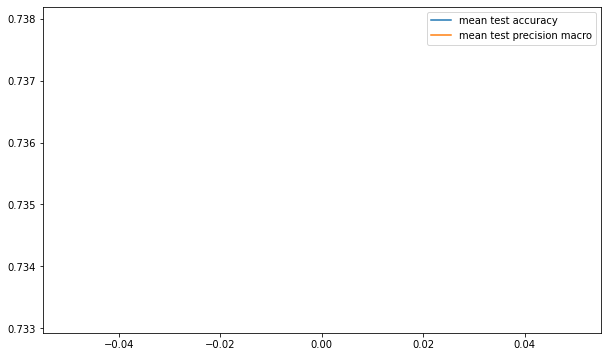

In [12]:
# Plot the results of the grid search to see which parameters are the best for the model to use
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
# Sort grid results by ranking
grid_results_df = pd.DataFrame(grid.cv_results_)
grid_results_df.sort_values(by=['rank_test_accuracy'], ascending=False, inplace=True)
plt.plot(grid.cv_results_['mean_test_accuracy'], label='mean test accuracy')
plt.plot(grid.cv_results_['mean_test_precision_macro'], label='mean test precision macro')
plt.legend()
plt.show()

In [13]:
grid.best_params_

{'model': KNeighborsClassifier(metric='manhattan', n_neighbors=7, weights='distance'),
 'model__metric': 'manhattan',
 'model__n_neighbors': 7,
 'model__weights': 'distance',
 'pca__n_components': None}

In [14]:
grid.best_score_

0.7379556259904912

In [15]:
# Results by ranking
grid_results_df.sort_values(by=['rank_test_accuracy'], ascending=True, inplace=True)
grid_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__metric,param_model__n_neighbors,param_model__weights,param_pca__n_components,params,split0_test_accuracy,split1_test_accuracy,split2_test_accuracy,split3_test_accuracy,split4_test_accuracy,split5_test_accuracy,split6_test_accuracy,split7_test_accuracy,split8_test_accuracy,split9_test_accuracy,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,split0_train_accuracy,split1_train_accuracy,split2_train_accuracy,split3_train_accuracy,split4_train_accuracy,split5_train_accuracy,split6_train_accuracy,split7_train_accuracy,split8_train_accuracy,split9_train_accuracy,mean_train_accuracy,std_train_accuracy,split0_test_precision_macro,split1_test_precision_macro,split2_test_precision_macro,split3_test_precision_macro,split4_test_precision_macro,split5_test_precision_macro,split6_test_precision_macro,split7_test_precision_macro,split8_test_precision_macro,split9_test_precision_macro,mean_test_precision_macro,std_test_precision_macro,rank_test_precision_macro,split0_train_precision_macro,split1_train_precision_macro,split2_train_precision_macro,split3_train_precision_macro,split4_train_precision_macro,split5_train_precision_macro,split6_train_precision_macro,split7_train_precision_macro,split8_train_precision_macro,split9_train_precision_macro,mean_train_precision_macro,std_train_precision_macro
0,0.051773,0.006,0.316856,0.04784,"KNeighborsClassifier(metric='manhattan', n_nei...",manhattan,7,distance,None,{'model': KNeighborsClassifier(metric='manhatt...,0.72504,0.745642,0.731379,0.732171,0.714739,0.748811,0.744849,0.732171,0.751981,0.752773,0.737956,0.01207,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.719653,0.739886,0.727251,0.728331,0.713786,0.742184,0.73861,0.730315,0.743191,0.748456,0.733166,0.01056,1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0


In [38]:
preprocessed_data = preprocessor.fit_transform(X)

preprocessed_dataframe = pd.DataFrame(preprocessed_data, columns=preprocessor.get_feature_names_out())
preprocessed_dataframe

2022/04/28 17:31:55 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '5c25aee687674ff7b48b68fdc01af7e8', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/04/28 17:31:55 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
2022/04/28 17:31:55 WARNING mlflow.sklearn: Failed to infer model signature: the trained model does not specify a `predict` function, which is required in order to infer the signature
2022/04/28 17:31:58 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'd7f60722f0e64131bab2298200c541a6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2022/04/28 17:31:58 WARNING mlflow.sklearn: Training metrics

,temperatureFirstHalfPlanetRotation,temperatureSecondHalfPlanetRotation,waterStreamDistanceX,waterStreamDistanceY,planetSection_Hyrule,planetSection_Mordor,planetSection_Tatoooine,cover_1,cover_2,cover_3,cover_4,climaticZone,geoZone_1,geoZone_2,geoZone_5,geoZone_7,rockSize_1,rockSize_2,rockSize_3,magmaConcentrationDistance_CLOSE,magmaConcentrationDistance_FAR,magmaConcentrationDistance_MEDIUM,magmaConcentrationDistance_VERY_CLOSE,magmaConcentrationDistance_VERY_FAR,mineralDensity,detectionDepth,longitude
0,0.000000,0.062969,0.177788,-0.561392,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,-1.024300,0.036297,-0.816631
1,-0.121687,1.300463,-0.923458,-0.637252,0.0,0.0,1.0,0.0,0.0,0.0,0.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.421035,-0.008990,2.183750
2,0.950602,0.705213,-0.924247,-0.804866,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.000000,1.170855,-1.171792
3,0.528915,-0.469623,-0.876572,-0.641185,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000,-1.188836,-0.167580
4,0.914457,0.156956,-1.074219,-0.835997,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-1.197034,-0.988620,-0.429381
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12616,-0.892772,-1.111866,-0.872966,-0.673135,0.0,1.0,0.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.618763,1.421126,-0.462613
12617,0.818072,1.472772,0.231856,-0.178976,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,-0.517071,0.339005,1.864209
12618,0.781927,0.767871,0.626084,-0.506668,0.0,1.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.000000,1.085048,-1.252170
12619,0.263855,1.300463,4.127995,2.629992,0.0,0.0,1.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.481407,1.256662,2.158515


<AxesSubplot:>

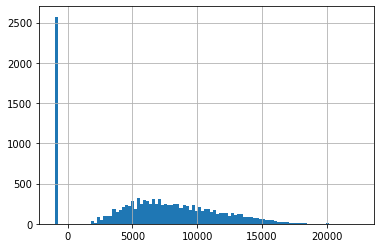

In [39]:
train['mineralDensity'].hist(bins=100)

<AxesSubplot:>

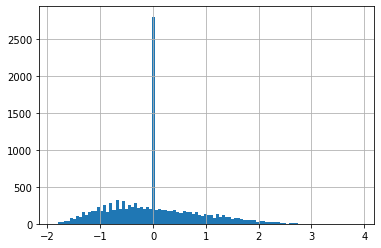

In [40]:
preprocessed_dataframe['mineralDensity'].hist(bins=100)

<AxesSubplot:>

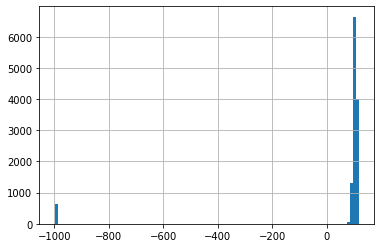

In [41]:
train['temperatureFirstHalfPlanetRotation'].hist(bins=100)

<AxesSubplot:>

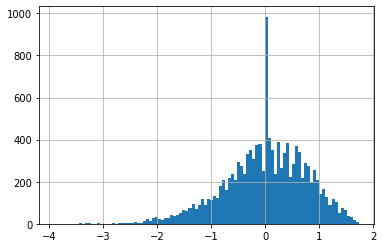

In [42]:
preprocessed_dataframe['temperatureFirstHalfPlanetRotation'].hist(bins=100)

In [43]:
grid.best_estimator_.score(X, y)

1.0

In [44]:
# preprocessor = ColumnTransformer([
#         # (name, transformer, columns)
#         ("temperatureFirstHalfPlanetRotation", make_pipeline(IterativeImputer(missing_values=-999.0), FunctionTransformer(lambda f: (f - 32) / 1.8, feature_names_out="one-to-one"), RobustScaler()), ['temperatureFirstHalfPlanetRotation']), # convert from Fahrenheit to Celsius
#         ("temperatureSecondHalfPlanetRotation", StandardScaler(), ['temperatureSecondHalfPlanetRotation']), # pass through the column unchanged
#         ("waterStreamDistanceX", make_pipeline(FunctionTransformer(lambda f: f * 0.3048, feature_names_out="one-to-one"), StandardScaler()), ['waterStreamDistanceX']), # convert from feet to meters
#         ("waterStreamDistanceY", StandardScaler(), ['waterStreamDistanceY']), # pass through the column unchanged
#         ("planetSection", OneHotEncoder(handle_unknown = "ignore"), ['planetSection']), # one-hot encode the planetSection column
#         ("cover", OneHotEncoder(handle_unknown='error', drop='first'), ['cover']), # one-hot encode the cover column and drop the first column (the one with the missing values == 0)
#         ("climaticZone", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ['climaticZone']), # ordinal encode the climaticZone column TODO: drop category 3? what to do? only one row has a 3
#         ("geoZone", OneHotEncoder(handle_unknown = "ignore"), ['geoZone']), # one-hot encode the geoZone column TODO: drop category 5?
#         ("rockSize", OneHotEncoder(handle_unknown='ignore', drop='first'), ['rockSize']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0)
#         ("magmaConcentrationDistance", OneHotEncoder(handle_unknown = "ignore"), ['magmaConcentrationDistance']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0) TODO: use Ordinal Encoder?
#         ("mineralDensity", make_pipeline(IterativeImputer(missing_values=-999.0), RobustScaler()), ['mineralDensity']), # pass through the column unchanged
#         ("detectionDepth", StandardScaler(), ['detectionDepth']), # pass through the column unchanged TODO: convert km to m?
#         ("longitude", StandardScaler(), ['longitude']), # pass through the column unchanged TODO: values > 360? do x - 360
#     ],
#     verbose_feature_names_out=False, remainder='passthrough'
# )

# def euclidean_distance(x, y):
#     res = []
#     for i in range(len(x)):
#         res.append(math.sqrt(x[i]**2 + y[i]**2))
#     return np.array(res)

# class CreateVariables(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
        
#     def fit(self, X, y = None):
#         return self

#     def transform(self, X, y = None):
#         # waterSteamDistance
#         waterStreamDistanceX = X[:,2]
#         waterStreamDistanceY = X[:,3]
#         waterStreamDistance = euclidean_distance(waterStreamDistanceX, waterStreamDistanceY)
#         X = np.append(X, waterStreamDistance.reshape(-1, 1), axis=1)

#         # temperature (both planet rotations)
#         temperatureFirstHalfPlanetRotation = X[:,0]
#         temperatureSecondHalfPlanetRotation = X[:,1]
#         meanTemperature = (temperatureFirstHalfPlanetRotation + temperatureSecondHalfPlanetRotation)/2
#         X = np.append(X, meanTemperature.reshape(-1, 1), axis=1)

#         return X

# pipe = Pipeline([
#     ('preprocessor', preprocessor),
#     ('create_variables', CreateVariables()),
# ])

# preprocessed_data = pipe.fit_transform(X, y)
# reduced_data = PCA(n_components=2).fit_transform(preprocessed_data, y)

# print(preprocessed_data.shape)
# print(reduced_data.shape)

# # reduced_data

# # # Plot the PCA results in a scatter plot with the color of the mineral density with a legend
# plt.figure(figsize=(10, 6))
# plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=y, cmap='viridis')
# plt.xlabel('PC1')
# plt.ylabel('PC2')
# plt.title('PCA of the data')
# plt.legend()
# plt.show()

In [45]:
# preprocessor = ColumnTransformer([
#         # (name, transformer, columns)
#         ("temperatureFirstHalfPlanetRotation", make_pipeline(IterativeImputer(missing_values=-999.0), FunctionTransformer(lambda f: (f - 32) / 1.8, feature_names_out="one-to-one"), RobustScaler()), ['temperatureFirstHalfPlanetRotation']), # convert from Fahrenheit to Celsius
#         ("temperatureSecondHalfPlanetRotation", StandardScaler(), ['temperatureSecondHalfPlanetRotation']), # pass through the column unchanged
#         ("waterStreamDistanceX", make_pipeline(FunctionTransformer(lambda f: f * 0.3048, feature_names_out="one-to-one"), StandardScaler()), ['waterStreamDistanceX']), # convert from feet to meters
#         ("waterStreamDistanceY", StandardScaler(), ['waterStreamDistanceY']), # pass through the column unchanged
#         ("planetSection", OneHotEncoder(handle_unknown = "ignore"), ['planetSection']), # one-hot encode the planetSection column
#         ("cover", OneHotEncoder(handle_unknown='error', drop='first'), ['cover']), # one-hot encode the cover column and drop the first column (the one with the missing values == 0)
#         ("climaticZone", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1), ['climaticZone']), # ordinal encode the climaticZone column TODO: drop category 3? what to do? only one row has a 3
#         ("geoZone", OneHotEncoder(handle_unknown = "ignore"), ['geoZone']), # one-hot encode the geoZone column TODO: drop category 5?
#         ("rockSize", OneHotEncoder(handle_unknown='ignore', drop='first'), ['rockSize']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0)
#         ("magmaConcentrationDistance", OneHotEncoder(handle_unknown = "ignore"), ['magmaConcentrationDistance']), # one-hot encode the rockSize column and drop the first column (the one with the missing values == 0) TODO: use Ordinal Encoder?
#         ("mineralDensity", make_pipeline(IterativeImputer(missing_values=-999.0), RobustScaler()), ['mineralDensity']), # pass through the column unchanged
#         ("detectionDepth", StandardScaler(), ['detectionDepth']), # pass through the column unchanged TODO: convert km to m?
#         ("longitude", StandardScaler(), ['longitude']), # pass through the column unchanged TODO: values > 360? do x - 360
#     ],
#     verbose_feature_names_out=False, remainder='passthrough'
# )

# def euclidean_distance(x, y):
#     res = []
#     for i in range(len(x)):
#         res.append(math.sqrt(x[i]**2 + y[i]**2))
#     return np.array(res)

# class CreateVariables(BaseEstimator, TransformerMixin):
#     def __init__(self):
#         pass
        
#     def fit(self, X, y = None):
#         return self

#     def transform(self, X, y = None):
#         # waterSteamDistance
#         waterStreamDistanceX = X[:,2]
#         waterStreamDistanceY = X[:,3]
#         waterStreamDistance = euclidean_distance(waterStreamDistanceX, waterStreamDistanceY)
#         X = np.append(X, waterStreamDistance.reshape(-1, 1), axis=1)

#         # temperature (both planet rotations)
#         temperatureFirstHalfPlanetRotation = X[:,0]
#         temperatureSecondHalfPlanetRotation = X[:,1]
#         meanTemperature = (temperatureFirstHalfPlanetRotation + temperatureSecondHalfPlanetRotation)/2
#         X = np.append(X, meanTemperature.reshape(-1, 1), axis=1)

#         return X

# pipe = Pipeline([
#     ('preprocessor', preprocessor),
#     ('create_variables', CreateVariables())
# ])

# preprocessed_data = pipe.fit_transform(X, y)
# reduced_data = PCA(n_components=3).fit_transform(preprocessed_data, y)

# print(preprocessed_data.shape)
# print(reduced_data.shape)

# # reduced_data

# # Create a dataframe with the reduced data and the labels
# reduced_data_df = pd.DataFrame(reduced_data, columns=['PC1', 'PC2', 'PC3'])
# reduced_data_df['mineralDensity'] = y

# # Create an interactive 3D scatter plot of the PCA results with the color of the mineral density with a legend in plotly express
# import plotly.express as px

# fig = px.scatter_3d(
#     reduced_data_df,
#     x='PC1',
#     y='PC2',
#     z='PC3',
#     color='mineralDensity',
#     color_continuous_scale=px.colors.sequential.Viridis,
#     opacity=0.8,
#     title='PCA of the data'
# )
# fig.show()

------------------------------------------

In [20]:
X_submit = test.drop(['id'], axis=1)

X_submit['planetSection'] = X_submit['planetSection'].astype('category')
X_submit['geoZone'] = X_submit['geoZone'].astype('category')
X_submit['rockSize'] = X_submit['rockSize'].astype('category')
X_submit['cover'] = X_submit['cover'].astype('category')
X_submit['magmaConcentrationDistance'] = X_submit['magmaConcentrationDistance'].astype('category')

In [21]:
y_hat = grid.predict(X_submit)
y_hat

array([2, 6, 7, ..., 6, 6, 4])

In [22]:
np.savetxt('knn_submit_dropped_predictions.txt', [y_hat], delimiter=',', fmt='%d')

In [25]:
def count_differences(v1, v2):
    count = 0
    for i in range(len(v1)):
        if v1[i] != v2[i]:
            count += 1
    return count

In [26]:
f1 = open('submit_dropped_predictions.txt', 'r')
f2 = open('knn_submit_dropped_predictions.txt', 'r')
f3 = open('cv_submit_dropped_predictions.txt', 'r')

v1 = f1.read().split(',')
v2 = f2.read().split(',')
v3 = f3.read().split(',')

In [27]:
# auto vs. knn
count_differences(v1, v2)

328

In [28]:
# auto vs. auto cv
count_differences(v1, v3)

128

In [29]:
# knn vs. auto cv
count_differences(v2, v3)

271

In [31]:
def count_equal(v1, v2):
    count = 0
    for i in range(len(v1)):
        if v1[i] == v2[i]:
            count += 1
    return count

In [32]:
# auto vs. knn
count_equal(v1, v2)

1672

In [33]:
# auto vs. auto cv
count_equal(v1, v3)

1872

In [34]:
# knn vs. auto cv
count_equal(v2, v3)

1729

In [36]:
def count_equal3(v1, v2, v3):
    count = 0
    for i in range(len(v1)):
        if (v1[i] == v2[i]) and (v1[i] == v3[i]) and (v2[i] == v3[i]):
            count += 1
    return count

In [37]:
# auto vs. knn vs. auto cv
count_equal3(v1, v2, v3)

1641